<a href="https://colab.research.google.com/github/snscatter/AB_Testing/blob/main/Cookie_Cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A/B Testing of Cookie Cats**

**Context** - This dataset includes A/B test results of Cookie Cats to examine what happens when the first gate in the game was moved from level 30 to level 40. When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

**Content** - The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:



*   **userid:** A unique number that identifies each player.
*   **version:** Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
sum_gamerounds: the number of game rounds played by the player during the first 14 days after install.
* **retention_1:** Did the player come back and play 1 day after installing?
* **retention_7:** Did the player come back and play 7 days after installing?


When a player installed the game, he or she was randomly assigned to either.

## A/B Testing Objective

The primary goal of this analysis is to determine whether the placement of the progression gate significantly impacts player retention and engagement. Specifically, we aim to answer:

1. **Retention**:
   - Does gate placement at level 40 (`gate_40`) lead to higher 1-day and 7-day retention rates compared to level 30 (`gate_30`)?

2. **Engagement**:
   - Does gate placement affect the total number of game rounds (`sum_gamerounds`) played in the first 14 days?

In [ ]:
import kagglehub
mursideyarkin_mobile_games_ab_testing_cookie_cats_path = kagglehub.dataset_download('mursideyarkin/mobile-games-ab-testing-cookie-cats')

print('Data source import complete.')

100%|██████████| 487k/487k [00:00<00:00, 75.0MB/s]

Extracting files...
Data source import complete.


In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
from google.colab import files
    uploaded = files.upload()
    for filename in uploaded.keys():
        df = pd.read_csv(filename)
        print(df.head())

In [ ]:
# STEP 1: Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# STEP 2: Upload CSV file from local
uploaded = files.upload()  # You will be prompted to upload the CSV

# STEP 3: Read the uploaded file (assuming the file name is 'cookie_cats.csv')
df = pd.read_csv('cookie_cats.csv')



Saving cookie_cats.csv to cookie_cats (1).csv


In [ ]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


Descriptive Stats by Group:
        sum_gamerounds        retention_1 retention_7
                  mean median        mean        mean
version                                              
gate_30         52.456   17.0       0.448       0.190
gate_40         51.299   16.0       0.442       0.182


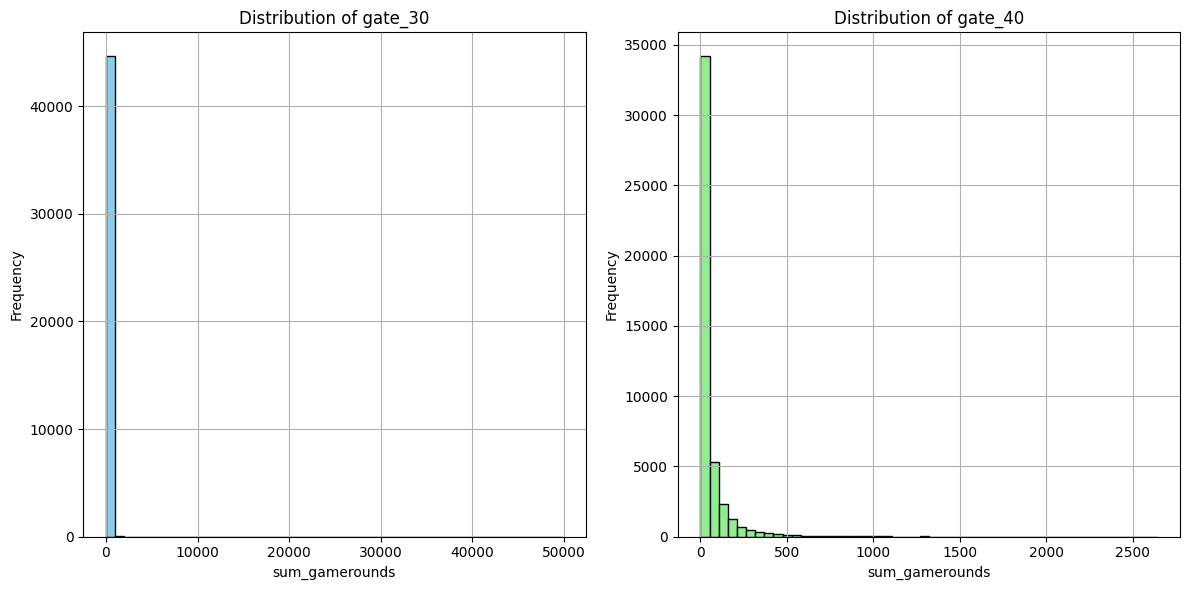

<ipython-input-11-f6e6f3cb7278>:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='version', y='retention_1', ci=None)


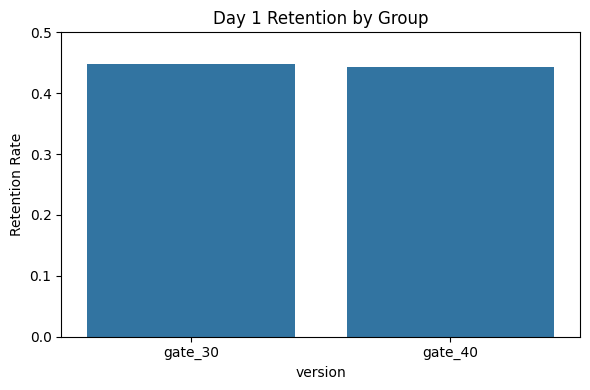

<ipython-input-11-f6e6f3cb7278>:48: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='version', y='retention_7', ci=None)


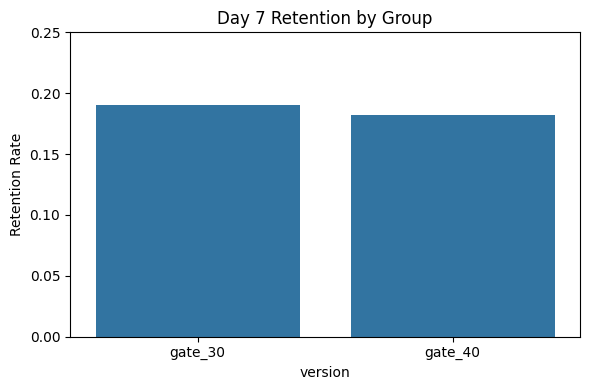

In [ ]:
# STEP 4: Descriptive Statistics by Version
grouped_stats = df.groupby('version').agg({
    'sum_gamerounds': ['mean', 'median'],
    'retention_1': 'mean',
    'retention_7': 'mean'
}).round(3)
print("Descriptive Stats by Group:")
print(grouped_stats)

# STEP 5: Distribution of Game Rounds (log-scaled y-axis)
def plot_histograms(df, col, group_col, group_1, group_2):

    plt.figure(figsize=(12, 6))


    plt.subplot(1, 2, 1)
    df[df[group_col] == group_1][col].hist(bins=50, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {group_1}")
    plt.xlabel(col)
    plt.ylabel("Frequency")


    plt.subplot(1, 2, 2)
    df[df[group_col] == group_2][col].hist(bins=50, color='lightgreen', edgecolor='black')
    plt.title(f"Distribution of {group_2}")
    plt.xlabel(col)
    plt.ylabel("Frequency")


    plt.tight_layout()
    plt.show()

plot_histograms(df, col="sum_gamerounds",
                group_col="version", group_1="gate_30",
                group_2="gate_40")

# STEP 6: Day 1 Retention Plot
plt.figure(figsize=(6, 4))
sns.barplot(data=df, x='version', y='retention_1', ci=None)
plt.title("Day 1 Retention by Group")
plt.ylabel("Retention Rate")
plt.ylim(0, 0.5)
plt.tight_layout()
plt.show()

# STEP 7: Day 7 Retention Plot
plt.figure(figsize=(6, 4))
sns.barplot(data=df, x='version', y='retention_7', ci=None)
plt.title("Day 7 Retention by Group")
plt.ylabel("Retention Rate")
plt.ylim(0, 0.25)
plt.tight_layout()
plt.show()


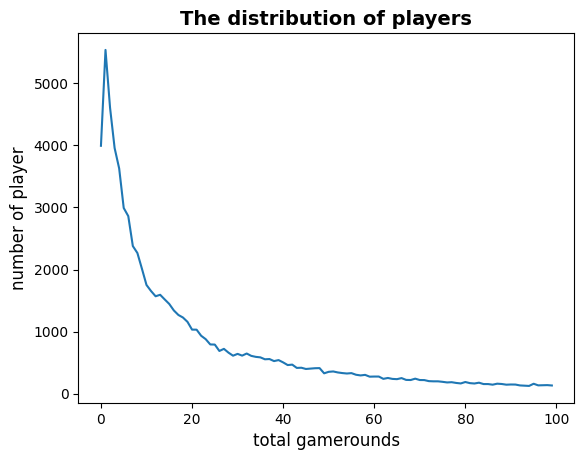

In [ ]:
# The distribution of game rounds

# Counting the number of players for each number of gamerounds
plot_df = df.groupby("sum_gamerounds")["userid"].count()

# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_df.head(100).plot()
plt.title("The distribution of players", fontweight="bold", size=14)
plt.xlabel("total gamerounds", size=12)
plt.ylabel("number of player", size=12)
plt.show()

# **Key Observations from Descriptive Stats & Distribution**

**Game Rounds Played (sum_gamerounds)**

The distribution is heavily right-skewed, with a small number of players playing hundreds or even thousands of rounds.

Most players play fewer rounds (peaks are concentrated toward the left).

**Retention Rates**

Day 1 and Day 7 retention rates appear visually slightly different between the two groups.

We'll test statistically later, but early signs suggest that gate placement might affect player behavior.

**Outliers in Game Rounds**

A small number of users played an unusually large number of rounds, likely distorting the averages.

These extreme values can bias statistical results, so it's good practice to analyze with and without outliers.

**Why Remove Outliers?**

Outliers can significantly affect mean, variance, and test results (especially parametric ones).

We'll use the **Interquartile Range (IQR) method**:

*   Keeps the middle 50% of the data (Q1 to Q3)
*   Removes anything 1.5×IQR above Q3 or 1.5×IQR below Q1.

This is a standard, robust method for skewed data (like we have here).

Lower Bound: -64.0
Upper Bound: 120.0

Original dataset size: 90189
After removing outliers: 80012


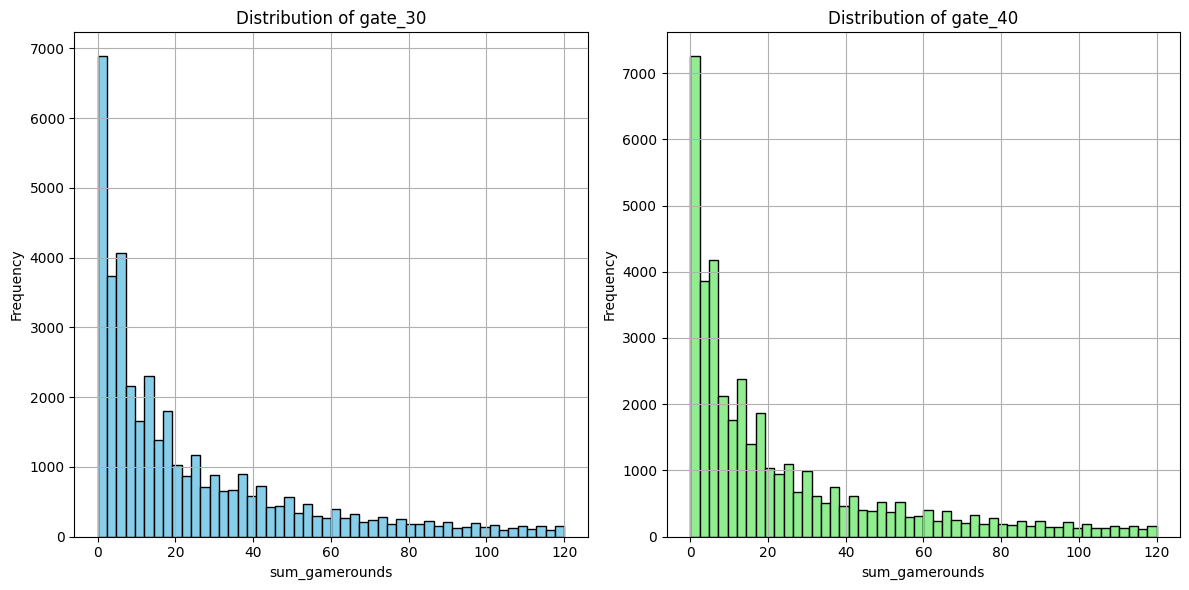

In [ ]:
# Step 1: Calculate Q1, Q3, and IQR
Q1 = df['sum_gamerounds'].quantile(0.25)
Q3 = df['sum_gamerounds'].quantile(0.75)
IQR = Q3 - Q1

# Step 2: Define upper and lower bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")

# Step 3: Remove outliers
df_no_outliers = df[(df['sum_gamerounds'] >= lower_bound) & (df['sum_gamerounds'] <= upper_bound)]
print(f"\nOriginal dataset size: {df.shape[0]}")
print(f"After removing outliers: {df_no_outliers.shape[0]}")

# Step 4: Optional - Plot again without outliers
plot_histograms(df_no_outliers, col="sum_gamerounds",
                group_col="version", group_1="gate_30",
                group_2="gate_40")


# **Choosing the Right Statistical Tests**

🔍 **Retention Day 1 and Day 7**

Both are binary variables (1 = retained, 0 = not retained).

We compare proportions of players who returned in each group.

✅ Best Test: Chi-square test of independence

🎮 **Game Rounds Played**

sum_gamerounds is continuous, not normally distributed, and heavily right-skewed.

✅ Best Test: Mann-Whitney U Test (non-parametric alternative to t-test, compares medians/distributions)

# **Establish the Hypotheses**

**H₀ (Null Hypothesis):** M₁ = M₂

There is no statistical difference between gate_30 and gate_40.

**H₁ (Alternative Hypothesis):** M₁ ≠ M₂

There is a statistical difference between gate_30 and gate_40.

In [ ]:
from scipy.stats import chi2_contingency, mannwhitneyu

# Filter out outliers from earlier
df_filtered = df_no_outliers  # this is from the IQR filtering step

# Running descriptive stats again
grouped_stats = df_filtered.groupby('version').agg({
    'sum_gamerounds': ['mean', 'median'],
    'retention_1': 'mean',
    'retention_7': 'mean'
}).round(3)
print("Descriptive Stats by Group:")
print(grouped_stats)

# 1. Chi-square Test for Retention Day 1
contingency_ret1 = pd.crosstab(df_filtered['version'], df_filtered['retention_1'])
chi2_1, p_1, _, _ = chi2_contingency(contingency_ret1)
print("\nRetention Day 1 - Chi-Square Test")
print(f"P-value: {p_1:.4f}")
print("Significant difference!" if p_1 < 0.05 else "No significant difference.\n")

# 2. Chi-square Test for Retention Day 7
contingency_ret7 = pd.crosstab(df_filtered['version'], df_filtered['retention_7'])
chi2_7, p_7, _, _ = chi2_contingency(contingency_ret7)
print("Retention Day 7 - Chi-Square Test")
print(f"P-value: {p_7:.4f}")
print("Significant difference!" if p_7 < 0.05 else "No significant difference.\n")

# 3. Mann-Whitney U Test for sum_gamerounds
group_30 = df_filtered[df_filtered['version'] == 'gate_30']['sum_gamerounds']
group_40 = df_filtered[df_filtered['version'] == 'gate_40']['sum_gamerounds']
u_stat, p_rounds = mannwhitneyu(group_30, group_40, alternative='two-sided')
print("\nGame Rounds Played - Mann-Whitney U Test")
print(f"P-value: {p_rounds:.4f}")
print("Significant difference!" if p_rounds < 0.05 else "No significant difference.\n")


Descriptive Stats by Group:
        sum_gamerounds        retention_1 retention_7
                  mean median        mean        mean
version                                              
gate_30         23.945   13.0       0.389       0.118
gate_40         24.013   13.0       0.383       0.110

Retention Day 1 - Chi-Square Test
P-value: 0.0974
No significant difference.

Retention Day 7 - Chi-Square Test
P-value: 0.0002
Significant difference!

Game Rounds Played - Mann-Whitney U Test
P-value: 0.0389
Significant difference!


In [ ]:
summary_df = pd.DataFrame({
    "Test": ["Retention Day 1", "Retention Day 7", "Game Rounds Played"],
    "Test Type": ["Chi-Square", "Chi-Square", "Mann-Whitney U"],
    "P-Value": [p_1, p_7, p_rounds],
    "Statistically Significant": [p_1 < 0.05, p_7 < 0.05, p_rounds < 0.05 if pd.notnull(p_rounds) else None]
})

summary_df

,Test,Test Type,P-Value,Statistically Significant
0,Retention Day 1,Chi-Square,0.097441,False
1,Retention Day 7,Chi-Square,0.000222,True
2,Game Rounds Played,Mann-Whitney U,0.038855,True


# 📊 **AB Test Results Summary**

**Retention Day 1 – Chi-Square Test**

P-value: 0.0974.

There is no significant difference between the control group (gate at level 30) and the test group (gate at level 40) in terms of Day 1 retention. Players returned at a similar rate one day after installation regardless of gate placement.

**Retention Day 7 – Chi-Square Test**

P-value: 0.0002

There is a statistically significant difference in Day 7 retention. This suggests that moving the gate to level 40 had a notable impact on longer-term player engagement, possibly making players less likely to return after a week.

**Game Rounds Played – Mann-Whitney U Test**

P-value: 0.0389

There is a statistically significant difference in the number of rounds played between the two groups. However, the mean and median are very similar, which implies the difference, while statistically detectable, may not be practically meaningful.

# **Conclusion**
Stick with the gate at level 30, since it encourages players to come back a week later — which is key to monetization and habit formation.